In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import get_close_matches

/Users/jacobv/ffml/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# fixes issue with autocomplete and pandas
%config Completer.use_jedi = False

In [3]:
player = pandas.read_csv('TPlayer.csv')
trans = pandas.read_csv('TransactionTable.csv')


In [4]:
adds = pandas.DataFrame(trans[trans.TransType=='Add'],copy=True)

In [5]:
adds.loc[:,'TransCosts'] = [0 if not pandas.notnull(x) else \
                           int(x.split(' ')[0]) \
                           for x in adds.TransCosts.values]

In [6]:
adds.loc[:,'By'] = [x.split(' ')[0] if 'via' in x\
                    else x for x in adds.By.values]

<AxesSubplot:xlabel='TransCosts', ylabel='Count'>

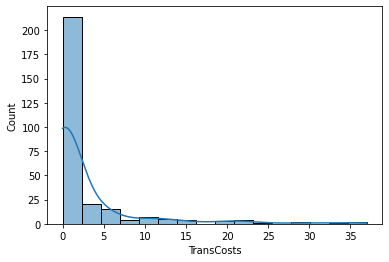

In [7]:
sns.histplot(adds.TransCosts,kde=True,bins=16)

In [8]:
adds.head()

,Date,Week,TransType,Player,Position,Team,From,To,By,TransCosts
23,2020-09-10 00:13:00,1,Add,Chris Boswell,K,PIT,Waivers,Eatin W's,Graham,0
24,2020-09-10 00:13:00,1,Add,James Robinson,RB,JAX,Waivers,Gronk's New Groove,Sam,1
25,2020-09-10 00:13:00,1,Add,Philadelphia Eagles DEF,DEF,PHI,Waivers,Eatin W's,Graham,1
31,2020-09-10 08:41:00,1,Add,Younghoe Koo,K,ATL,Free Agents,Fantasy Football Team,Liam,0
36,2020-09-10 10:50:00,1,Add,Jason Myers,K,SEA,Free Agents,The Wet Market Pangolins,Jake,0


In [9]:
player.head()

,name,position,team,unique_str,week,owner,points,status,RostStatus
0,"Watson, D.",QB,HOU,"Watson, D. QB HOU",1,Jake,20.82,Active,Starting
1,Panthers DEF,DEF,Panthers,Panthers DEF,1,FA,NaN,FA,FA
2,"Renfrow, H.",WR,LV,"Renfrow, H. WR LV",1,FA,NaN,FA,FA
3,Browns DEF,DEF,Browns,Browns DEF,1,FA,NaN,FA,FA
4,"Miller, S.",WR,TB,"Miller, S. WR TB",1,FA,NaN,FA,FA


In [10]:
def get_unique_str(row):
    if row['Position'] == 'DEF':
        nsplit = row['Player'].split(' ')
        if 'Football Team' in row['Player']:
            pstr = '%s %s %s'%(nsplit[-3],nsplit[-2],nsplit[-1])
        else:
            pstr = '%s %s '%(nsplit[-2],nsplit[-1])
    else:
        nsplit = row['Player'].split(' ')
        name = ''
        for i in range(1,len(nsplit)):
            if i == len(nsplit)-1:
                name += '%s, '%nsplit[i]
            else:
                name += '%s '%nsplit[i]
        name += '%s.'%nsplit[0][0]
        pstr = '%s %s %s'%(name,row['Position'],row['Team'])
    
    return pstr

def get_stint(pdf,owner):
    inds = []
    for i,row in pdf.iterrows():
        if row['owner'] == owner:
            inds.append(i)
        else:
            break
    return inds

In [11]:
unis = player.unique_str.unique()
for i,row in adds.iterrows():
    pstr = get_unique_str(row)
    if pstr not in unis:
        match = get_close_matches(pstr,unis,cutoff=0.8)
        if len(match) > 0:
            pstr = match[0]
        else: 
            print('couldnt find a match for %s'%pstr)
            continue
    pdf = player[(player.unique_str==pstr) & (player.week>=row['Week'])]
    stindx = get_stint(pdf,row['By'])
    stint = player.loc[stindx]
    adds.loc[i,'N_Weeks'] = len(stint)
    adds.loc[i,'Total_Points'] = stint['points'].sum()
    adds.loc[i,'Earned_Points'] = stint[stint.status=='Active'
                                       ].points.sum()
    if row['TransCosts'] == 0:
        adds.loc[i,'TP_perDollar'] = adds.loc[i,'Total_Points']
        adds.loc[i,'EP_perDollar'] = adds.loc[i,'Earned_Points']
    else:
        adds.loc[i,'TP_perDollar'] = adds.loc[i,'Total_Points'] /\
                                     adds.loc[i,'TransCosts']
        adds.loc[i,'EP_perDollar'] = adds.loc[i,'Earned_Points'] /\
                                     adds.loc[i,'TransCosts']

couldnt find a match for Humphries, A. WR TEN
couldnt find a match for Goff, J. QB LA
couldnt find a match for Firkser, A. TE TEN
couldnt find a match for Perine, L. RB NYJ
couldnt find a match for Goff, J. QB LA


#### Best individual deals

In [12]:
cols = ['By','TransType','Player','Position','TransCosts','N_Weeks',
        'TP_perDollar','EP_perDollar']
adds.sort_values('EP_perDollar',ascending=False)[cols].head(10)

,By,TransType,Player,Position,TransCosts,N_Weeks,TP_perDollar,EP_perDollar
356,Jess,Add,Justin Herbert,QB,0,14.0,277.62,239.14
24,Sam,Add,James Robinson,RB,1,16.0,250.40,219.40
747,Jake,Add,T.J. Hockenson,TE,0,11.0,122.80,122.80
633,Liam,Add,Tee Higgins,WR,0,12.0,154.10,119.40
730,Liam,Add,Younghoe Koo,K,0,11.0,111.00,111.00
1100,Nolan,Add,Jason Sanders,K,0,9.0,95.00,95.00
868,Kevin,Add,Daniel Carlson,K,1,10.0,92.00,92.00
923,f,Add,J.D. McKissic,RB,0,10.0,134.10,90.70
1083,Liam,Add,Nyheim Hines,RB,0,9.0,141.60,82.70
1598,Liam,Add,Dallas Goedert,TE,0,6.0,73.80,73.80


#### Worst individual deals

In [15]:
adds.sort_values(['EP_perDollar','TransCosts'],
                 ascending=[True,False])[cols].head(10)

,By,TransType,Player,Position,TransCosts,N_Weeks,TP_perDollar,EP_perDollar
1213,Graham,Add,Justin Jackson,RB,30,3.0,0.000000,0.0
282,Lucas,Add,Wayne Gallman,RB,24,4.0,0.512500,0.0
1985,Jake,Add,Salvon Ahmed,RB,20,1.0,0.065000,0.0
339,Matt,Add,T.Y. Hilton,WR,14,3.0,1.928571,0.0
395,Lucas,Add,Carlos Hyde,RB,12,3.0,0.000000,0.0
1930,Kevin,Add,T.Y. Hilton,WR,10,2.0,2.010000,0.0
874,Sam,Add,Tyler Higbee,TE,7,0.0,0.000000,0.0
1354,Matt,Add,Zack Moss,RB,7,1.0,0.385714,0.0
128,Graham,Add,Latavius Murray,RB,6,15.0,21.900000,0.0
590,Jake,Add,D'Ernest Johnson,RB,6,1.0,0.766667,0.0


#### Best points netting transactions

In [16]:
cols = ['By','TransType','Player','Position','TransCosts','N_Weeks',
        'Earned_Points','EP_perDollar']
adds.sort_values('Earned_Points',ascending=False)[cols].head(10)

,By,TransType,Player,Position,TransCosts,N_Weeks,Earned_Points,EP_perDollar
356,Jess,Add,Justin Herbert,QB,0,14.0,239.14,239.140000
24,Sam,Add,James Robinson,RB,1,16.0,219.40,219.400000
388,Lucas,Add,Justin Jefferson,WR,23,13.0,209.40,9.104348
882,f,Add,Ryan Tannehill,QB,11,10.0,181.12,16.465455
280,Jake,Add,Mike Davis,RB,28,14.0,173.90,6.210714
1038,Matt,Add,Tom Brady,QB,5,9.0,156.56,31.312000
735,Nolan,Add,Chase Claypool,WR,19,11.0,123.30,6.489474
747,Jake,Add,T.J. Hockenson,TE,0,11.0,122.80,122.800000
633,Liam,Add,Tee Higgins,WR,0,12.0,119.40,119.400000
290,Jake,Add,Rodrigo Blankenship,K,3,14.0,117.00,39.000000


#### Most net points off waiver wire

In [17]:
TAvg = adds.pivot_table(values=['TransCosts','Earned_Points'],index='By',
                        aggfunc=np.sum)
TAvg.sort_values('Earned_Points',ascending=False)

,Earned_Points,TransCosts
By,,
Liam,900.74,89
Matt,731.22,100
Sam,660.16,94
Jake,627.34,79
f,541.22,27
Lucas,481.90,82
Nolan,432.04,91
Jess,426.94,0
Graham,418.72,100


#### Overall Points per Dollar Spent

In [18]:
TAvg.loc[:,'PointsPerDollarSpent'] = TAvg['Earned_Points'] / TAvg['TransCosts']
TAvg.sort_values('PointsPerDollarSpent',ascending=False)

,Earned_Points,TransCosts,PointsPerDollarSpent
By,,,
Jess,426.94,0,inf
f,541.22,27,20.045185
Liam,900.74,89,10.120674
Jake,627.34,79,7.941013
Matt,731.22,100,7.312200
Sam,660.16,94,7.022979
Lucas,481.90,82,5.876829
Nolan,432.04,91,4.747692
Graham,418.72,100,4.187200


In [19]:
627.34 / 59 # I would have been second place if not for my SB antics

10.632881355932204

# Analyis: 
* Alex uses better spreadsheets than Graham
* Jess clearly understands the waiver wire better than any of us
* Liam lives on the waiver wire
* Nolan: perennial competitor, but not because of his waiver moves!